In [18]:
%matplotlib inline

import allel
import numpy as np
import pandas as pd
import zarr
from pathlib import Path
import scipy
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [19]:
%run tools.py

### GAARDIAN - Ghana - G12

In [28]:
sample_set = "1244-VO-GH-YAWSON-VMF00149"
chroms = ['2L', '2R', '3L', '3R', 'X']

snps = {}
pos = {}

for chrom in chroms:
    
    snps[chrom], pos[chrom], metadata = load_arrays_and_metadata("../resources", sample_set, chrom)
    
metadata['location2'] = metadata['location'].str.split(".").str.get(0)

How many do we have from each species?

In [6]:
metadata.species_gambiae_coluzzii.value_counts()

coluzzii    422
gambiae      63
Name: species_gambiae_coluzzii, dtype: int64

How many samples do we have from each village??

In [7]:
metadata.location2.value_counts()

Domenase         57
Annorkrom        49
New Edubiase     42
Pokukrom         37
Odumto           34
Koniyaw          32
Nkotumso         30
Kokotro          28
Prisintease      24
Kente            24
Watreso          19
Adansi Apagya    16
Wamase           16
Ankaako          12
Mprakyire        10
Anwona            8
Adumanu           6
Adansi-Krom       6
Yadome            6
Asonkore          5
Bogyawe           5
Jacobu            5
Fumso             4
Dompoase          3
Subin Camp        2
Anhwiaso          2
Bogobiri West     2
Mensonso          1
Name: location2, dtype: int64

## G12

In [9]:
def cluster_G12(gnalt, cut_height=0.1, metric='euclidean'):
    """
    Hierarchically clusters genotypes and calculates G12 statistic. 
    """
    # cluster the genotypes in the window
    dist = scipy.spatial.distance.pdist(gnalt.T, metric=metric)
    if metric in {'hamming', 'jaccard'}:
        # convert distance to number of SNPs, easier to interpret
        dist *= gnalt.shape[0]

    Z = scipy.cluster.hierarchy.linkage(dist, method='single')
    cut = scipy.cluster.hierarchy.cut_tree(Z, height=cut_height)[:, 0]
    cluster_sizes = np.bincount(cut)
    clusters = [np.nonzero(cut == i)[0] for i in range(cut.max() + 1)]
    
    # get freq of clusters and sort by largest freq
    freqs = cluster_sizes/gnalt.shape[1]
    freqs = np.sort(freqs)[::-1]
    
    # calculate g12
    g12 = np.sum(freqs[:2])**2 + np.sum(freqs[2:]**2)
    
    return(g12)

def garuds_G12(gnalt, pos, cut_height=None, save=False, prefix=None, name=None, metric='euclidean', window_size=1000, step_size=500, cluster=False, species=None):
    
    """
    Calculates G12, stores windows in .tsv and plots
    """
        
    # Do we want to cluster the Multi-locus genotypes (MLGs), or just group MLGs if they are identical
    if cluster:
        g12 = allel.moving_statistic(gnalt, cluster_G12, size=window_size, step=step_size, metric=metric, cut_height=cut_height)
    else:
        g12,_,_,_ = allel.moving_garud_h(gnalt, size=window_size, step=step_size)

    midpoint = allel.moving_statistic(pos, np.median, size=window_size, step=step_size)
    
    # store windowed G12 statistics as .tsv 
    df = pd.DataFrame({'midpoint':midpoint, 'G12':g12})
    df.to_csv(f"{prefix}/{name}.tsv", sep="\t", index=False)
    
    # create plot 
    xtick = np.arange(0, midpoint.max(), 2000000)
    ylim = np.max([0.50, g12.max()])
    plt.figure(figsize=[20,10])
    if species == 'gambiae':
        sns.lineplot(midpoint, g12, color='lightcoral')
    else:
        sns.lineplot(midpoint, g12, color='dodgerblue')
    plt.ylim(0, ylim)
    plt.xticks(xtick, rotation=45, ha='right')
    plt.ticklabel_format(style='plain', axis='x')
    plt.title(f"G12 {name}")
    if save: plt.savefig(f"{prefix}/{name}.png",format="png")
    
    plt.show()


### Run G12

--------- Running G12 on gambiae Chromosome 2L ----------
There are 4384894 segregating sites and 63 individuals


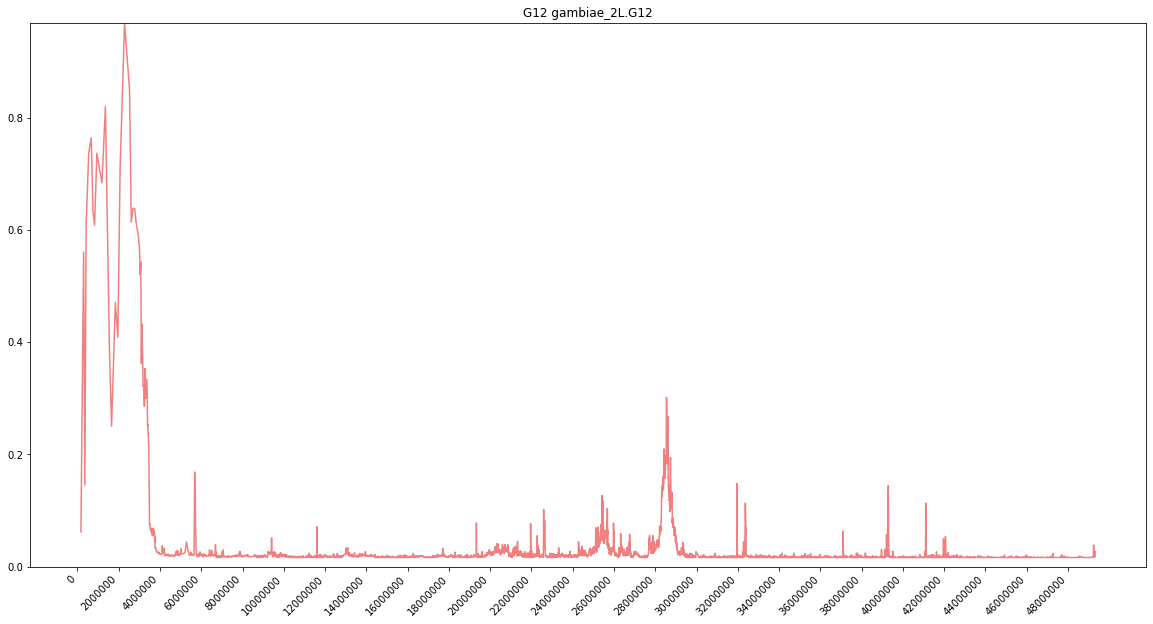

--------- Running G12 on coluzzii Chromosome 2L ----------
There are 6066416 segregating sites and 422 individuals


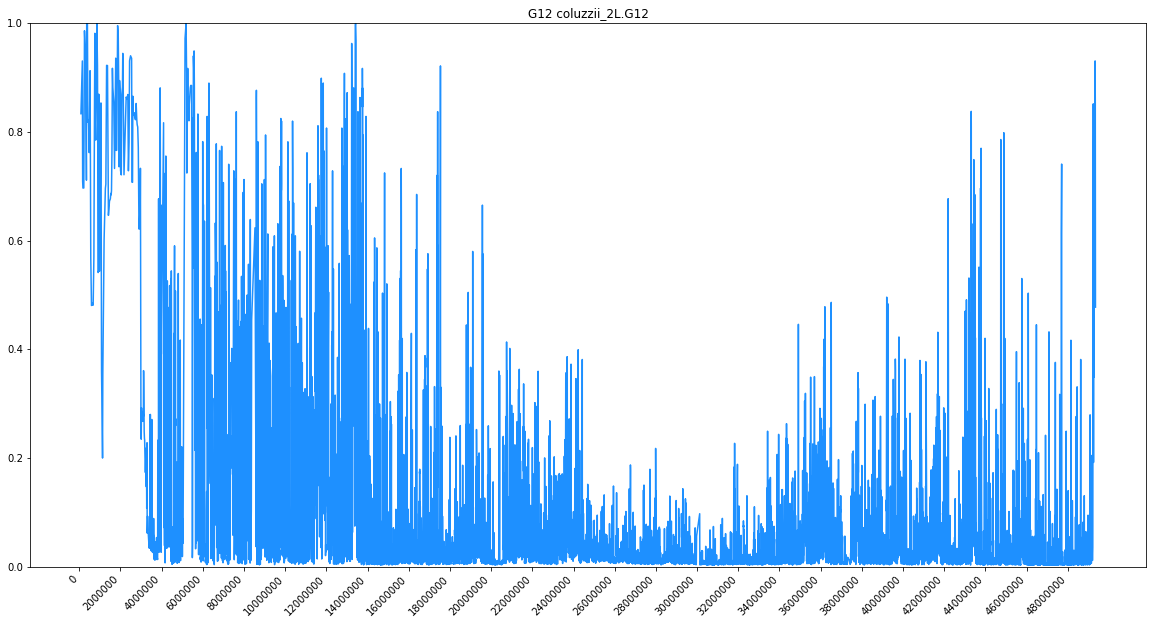

--------- Running G12 on gambiae Chromosome 2R ----------
There are 5323883 segregating sites and 63 individuals


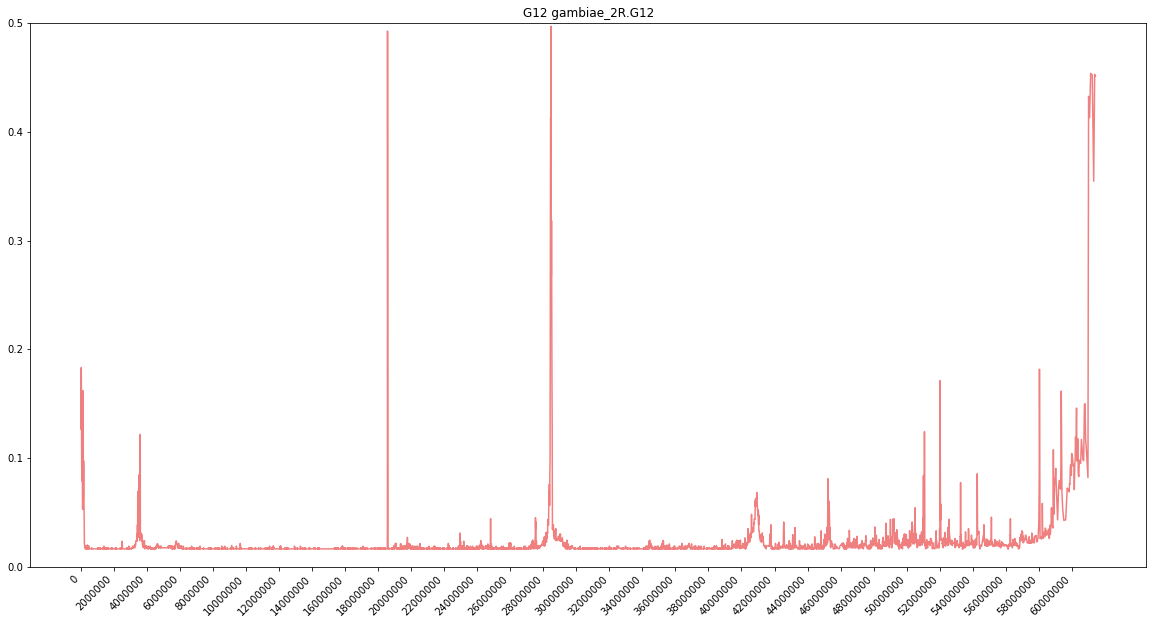

--------- Running G12 on coluzzii Chromosome 2R ----------
There are 6491331 segregating sites and 422 individuals


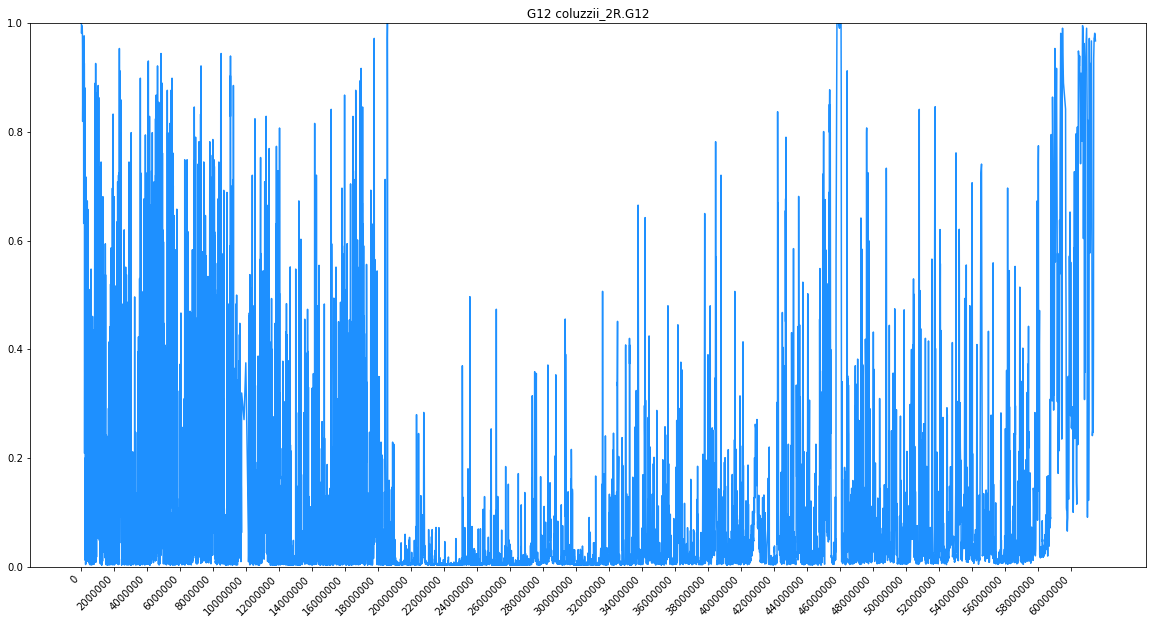

--------- Running G12 on gambiae Chromosome 3L ----------
There are 3631936 segregating sites and 63 individuals


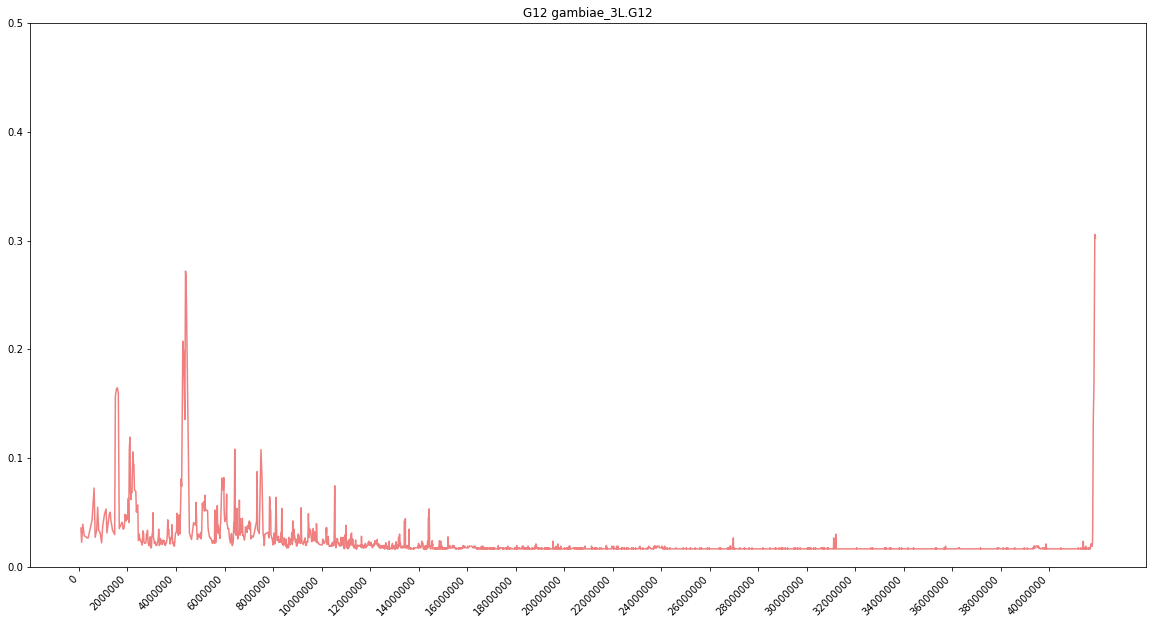

--------- Running G12 on coluzzii Chromosome 3L ----------
There are 5342227 segregating sites and 422 individuals


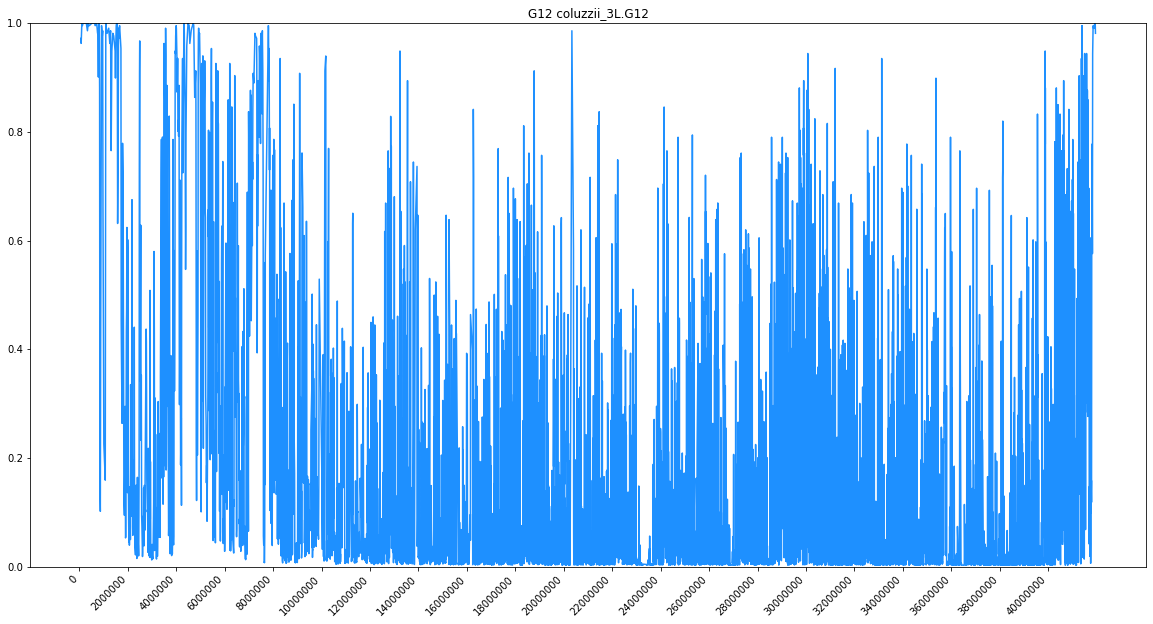

--------- Running G12 on gambiae Chromosome 3R ----------
There are 4993295 segregating sites and 63 individuals


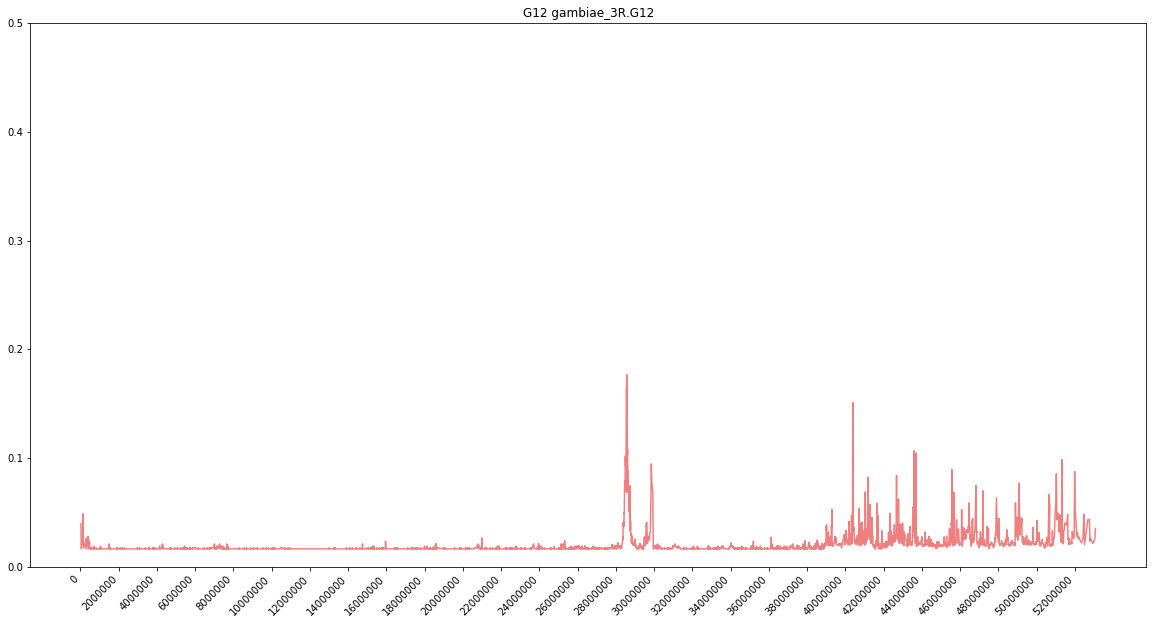

--------- Running G12 on coluzzii Chromosome 3R ----------
There are 7381382 segregating sites and 422 individuals


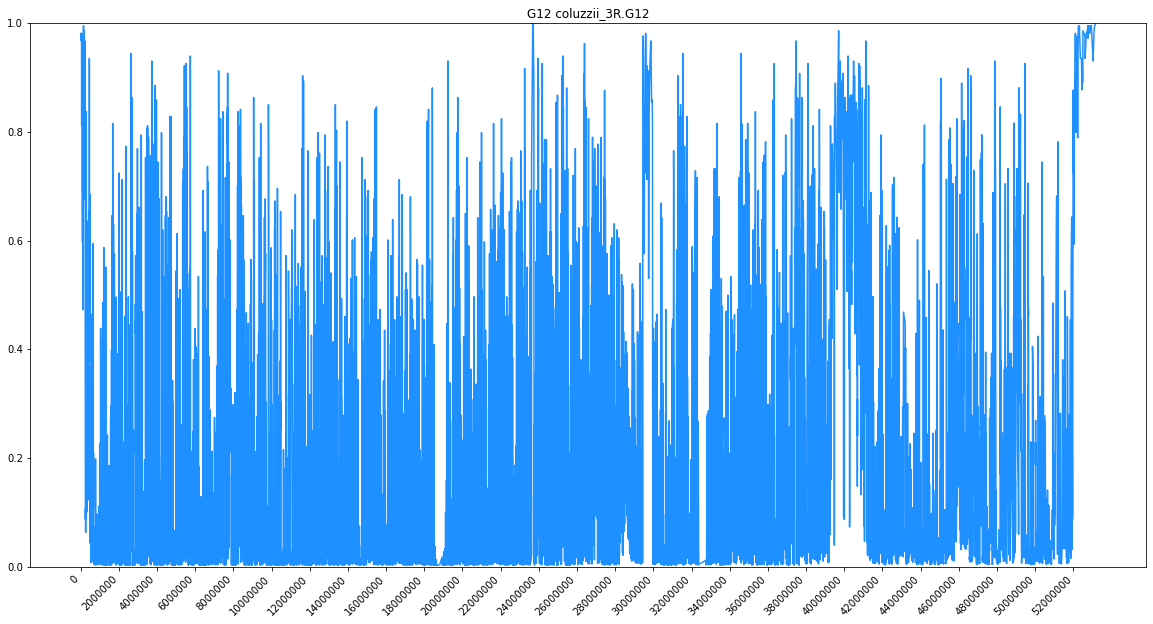

--------- Running G12 on gambiae Chromosome X ----------
There are 1700513 segregating sites and 63 individuals


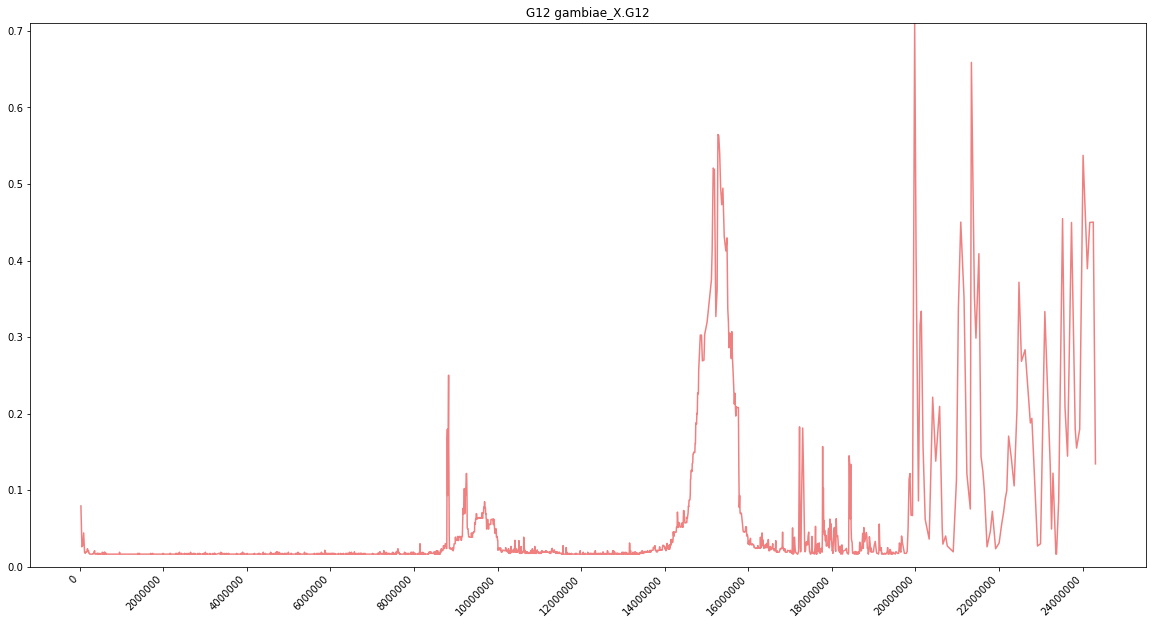

--------- Running G12 on coluzzii Chromosome X ----------
There are 2463937 segregating sites and 422 individuals


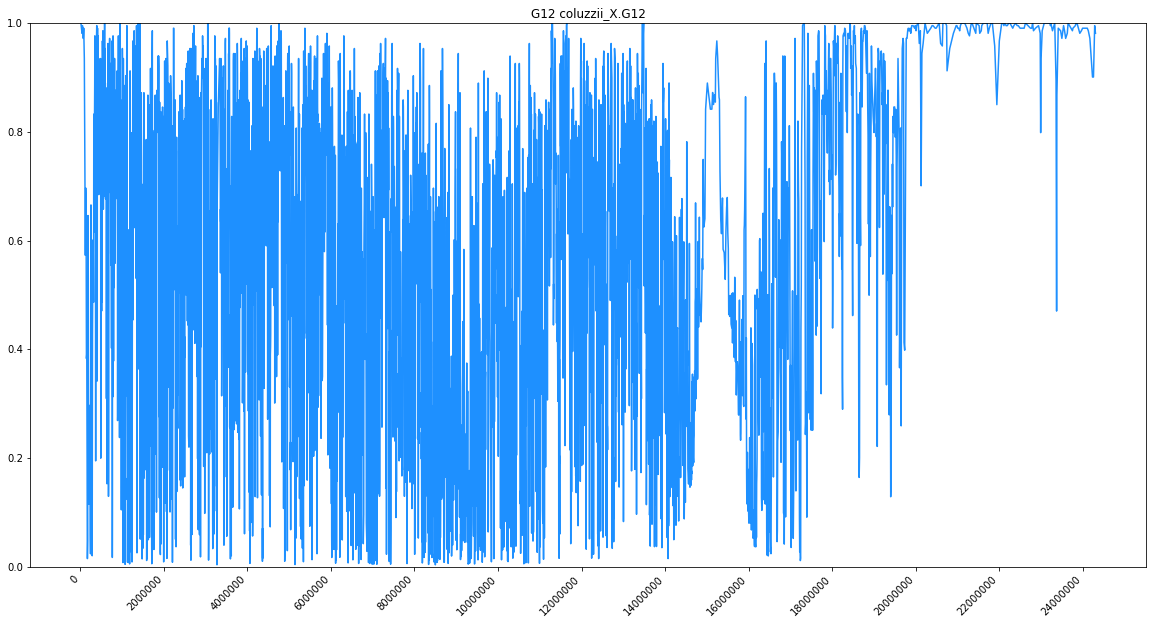

In [29]:
for chrom in chroms:
    
    # Count alleles per site
    ac = snps[chrom].count_alleles()
    # Get boolean array for biallelic or not
    bial_bool = ac.is_biallelic()
    # Filter arrays to biallelic only
    geno = snps[chrom].compress(bial_bool, axis=0)
    positions = pos[chrom][bial_bool]

            # have edited .species_gambiae_coluzzii column to contain 'arabiensis' instead of NA 
    for sp in metadata.species_gambiae_coluzzii.unique():

        #filter to species 
        nmeta3 = metadata[metadata.species_gambiae_coluzzii == sp]
        flt = np.array(nmeta3.index)
        # filter to correct loc, year, species individuals
        gn = geno.take(flt, axis=1)

        print(f"--------- Running G12 on {sp} Chromosome {chrom} ----------")

        # filter to segregating sites only as the phase 3 arrays contain every SNP on the chromosome
        seg = gn.count_alleles().is_segregating()
        gn = gn.compress(seg, axis=0)
        pos1 = positions[seg]

        print(f"There are {gn.shape[0]} segregating sites and {gn.shape[1]} individuals")

        # convert to 0,1,2 genotypes
        gn_alt = gn.to_n_alt().compute()

        # calculate G12 and plot figs 
        garuds_G12(gnalt=gn_alt, pos=pos1, cut_height=6,
                   save=True, 
                   prefix='../results',
                   name=f"{sp}_{chrom}.G12", 
                   metric='euclidean',
                  window_size=1000,
                  step_size=500, cluster=True, species=sp)

### Coluzzii only with altered cut height

In [31]:
colbool = metadata.species_gambiae_coluzzii == 'coluzzii'
colmeta = metadata[colbool]

--------- Running G12 on coluzzii Chromosome 2L ----------
There are 6465187 segregating sites and 422 individuals


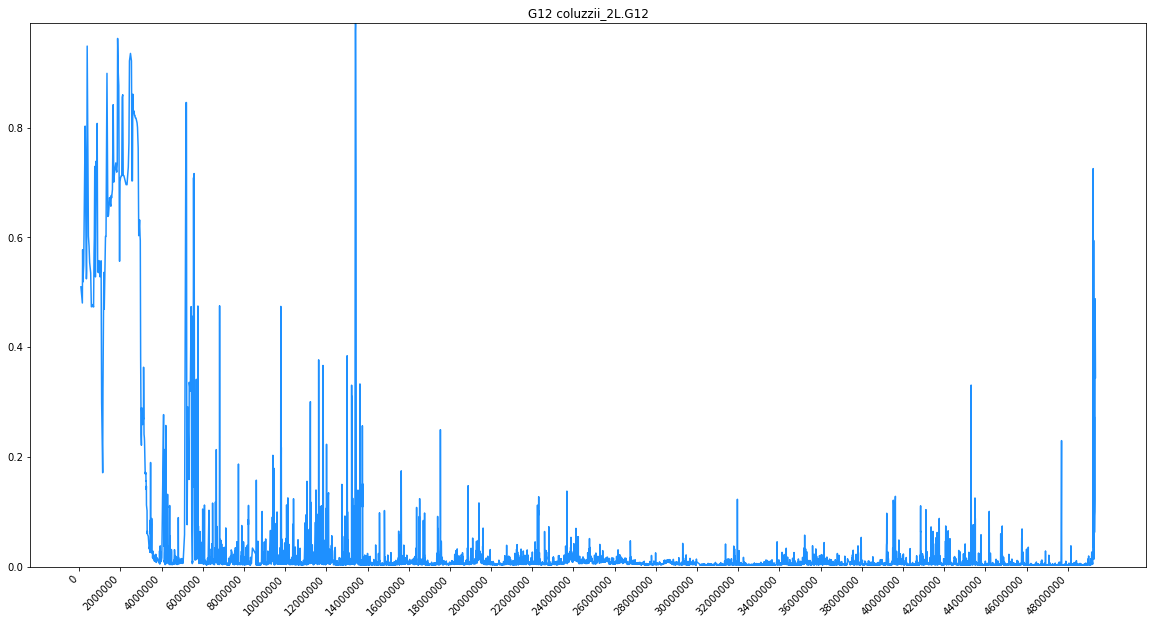

--------- Running G12 on coluzzii Chromosome 2R ----------
There are 7032346 segregating sites and 422 individuals


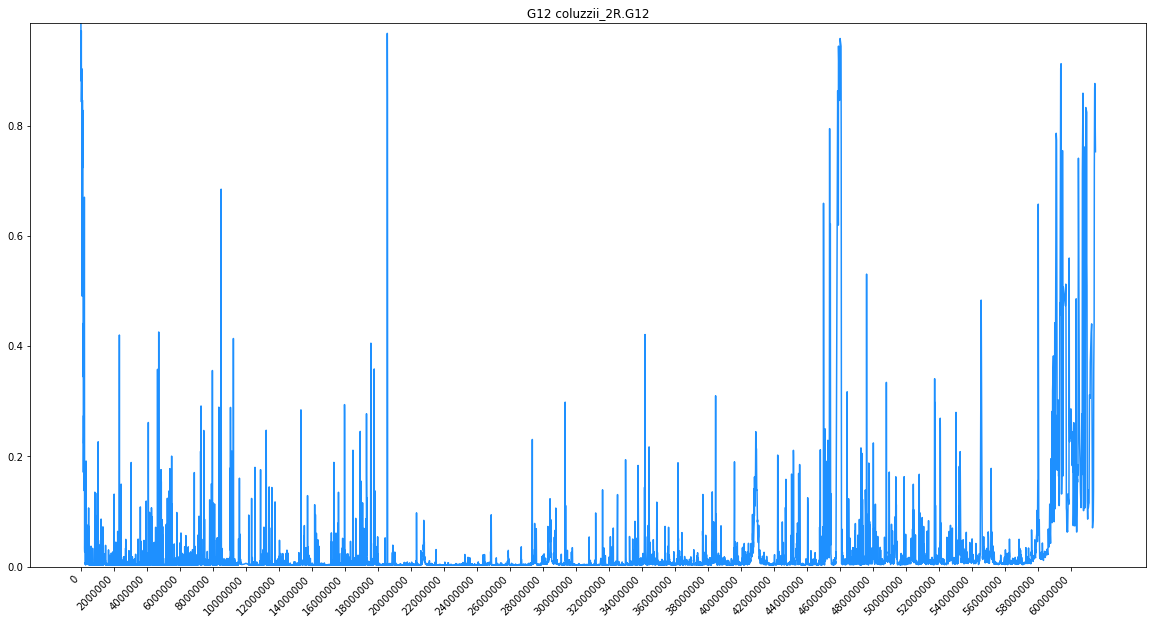

--------- Running G12 on coluzzii Chromosome 3L ----------
There are 5749134 segregating sites and 422 individuals


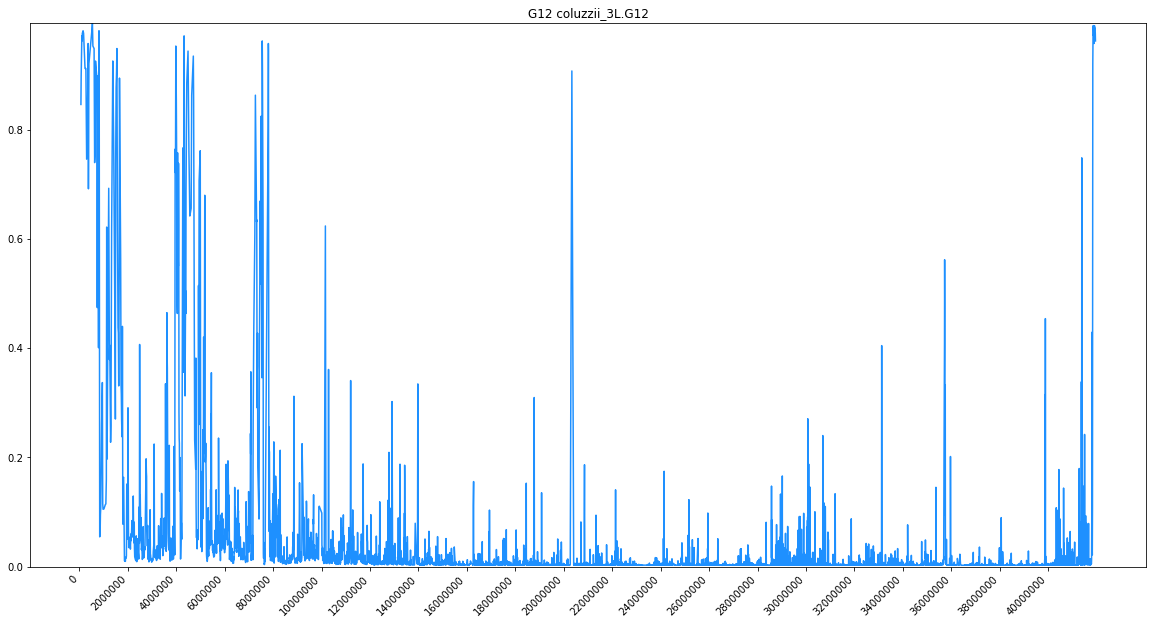

--------- Running G12 on coluzzii Chromosome 3R ----------
There are 7959589 segregating sites and 422 individuals


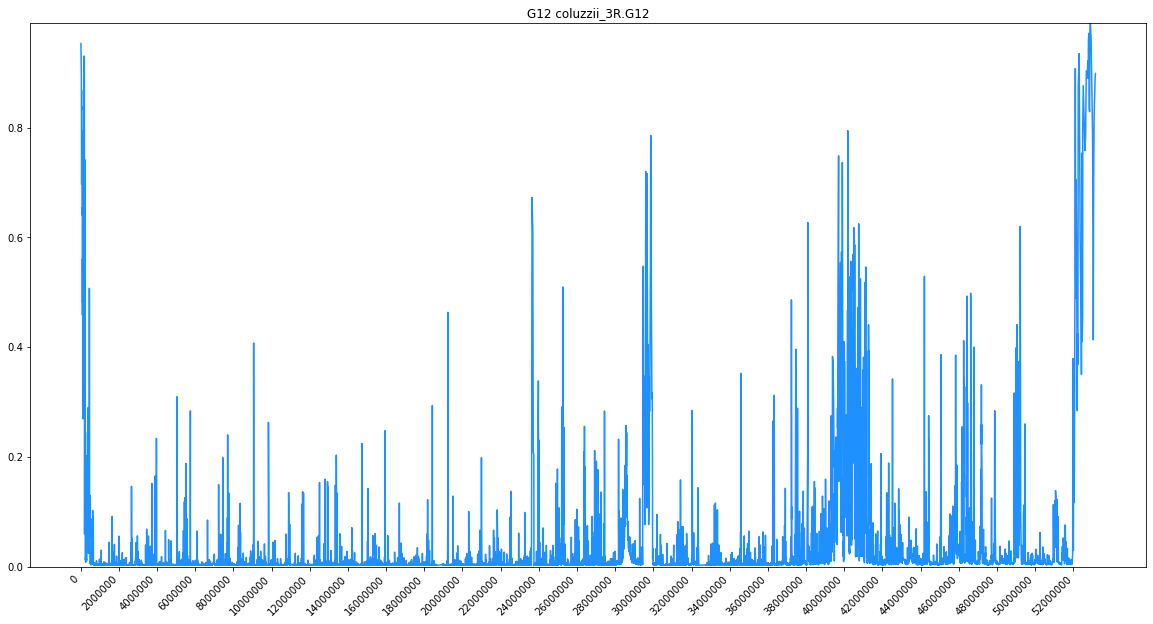

--------- Running G12 on coluzzii Chromosome X ----------
There are 2629996 segregating sites and 422 individuals


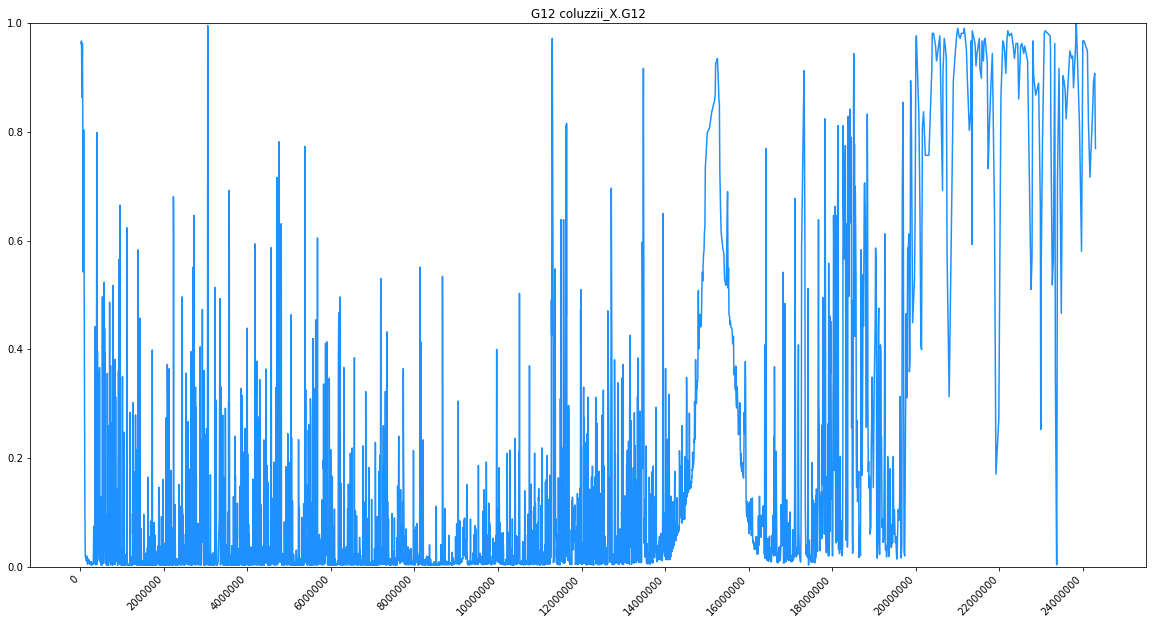

In [33]:
for chrom in chroms:
    
    # Count alleles per site
    ac = snps[chrom].compress(colbool, axis=1).count_alleles()
    # Get boolean array for biallelic or not
    bial_bool = ac.is_biallelic()
    # Filter arrays to biallelic only
    geno = snps[chrom].compress(bial_bool, axis=0)
    positions = pos[chrom][bial_bool]

            # have edited .species_gambiae_coluzzii column to contain 'arabiensis' instead of NA 
    for sp in colmeta.species_gambiae_coluzzii.unique():

        #filter to species 
        nmeta3 = metadata[metadata.species_gambiae_coluzzii == sp]
        flt = np.array(nmeta3.index)
        # filter to correct loc, year, species individuals
        gn = geno.take(flt, axis=1)

        print(f"--------- Running G12 on {sp} Chromosome {chrom} ----------")

        # filter to segregating sites only as the phase 3 arrays contain every SNP on the chromosome
        seg = gn.count_alleles().is_segregating()
        gn = gn.compress(seg, axis=0)
        pos1 = positions[seg]

        print(f"There are {gn.shape[0]} segregating sites and {gn.shape[1]} individuals")

        # convert to 0,1,2 genotypes
        gn_alt = gn.to_n_alt().compute()

        # calculate G12 and plot figs 
        garuds_G12(gnalt=gn_alt, pos=pos1, cut_height=5,
                   save=False, 
                   prefix='../results',
                   name=f"{sp}_{chrom}.G12", 
                   metric='euclidean',
                  window_size=1000,
                  step_size=500, cluster=True, species=sp)